Import Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.pipeline import Pipeline

Load & Prepare "Wine" Dataset

In [2]:
from sklearn.datasets import load_wine
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")
df = pd.concat([X, y], axis=1)

df.to_csv("../data/wine.csv", index=False)
display(df.head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Train-test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
y_train.value_counts().sort_index()

target
0    45
1    57
2    40
Name: count, dtype: int64

In [5]:
y_test.value_counts().sort_index()

target
0    14
1    14
2     8
Name: count, dtype: int64

Standardization

In [6]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Define Distance Metrics

In [7]:
distance_metrics = {
'euclidean': 'euclidean',
'manhattan': 'manhattan',
'chebyshev': 'chebyshev',
'minkowski_p3': {'metric': 'minkowski', 'p': 3},
'minkowski_p4': {'metric': 'minkowski', 'p': 4},
'cosine': 'cosine'
}

Mahalanobis Covariance Computation

In [8]:
cov = np.cov(X_train_std, rowvar=False)
VI = inv(cov)

# Add Mahalanobis to metrics list
distance_metrics_full = distance_metrics.copy()
distance_metrics_full['mahalanobis'] = {'metric': 'mahalanobis', 'VI': VI}

Evaluate KNN across Metrics

In [9]:
k_values = range(1, 31)
results = {}

for name, metric in distance_metrics_full.items():
    acc_list = []
    for k in k_values:
        if isinstance(metric, dict) and name.startswith('minkowski'):
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric['metric'], p=metric['p'])
        elif name == 'mahalanobis':
            knn = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'VI': VI})
        else:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)

        knn.fit(X_train_std, y_train)
        y_pred = knn.predict(X_test_std)
        acc_list.append(accuracy_score(y_test, y_pred))
    results[name] = acc_list

Individual Accuracy Curves

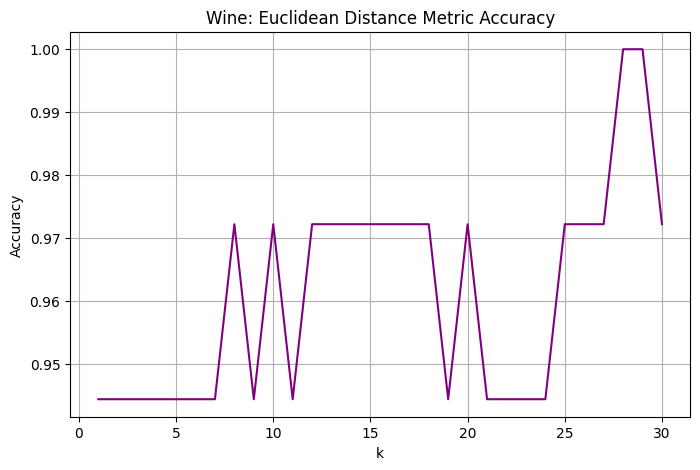

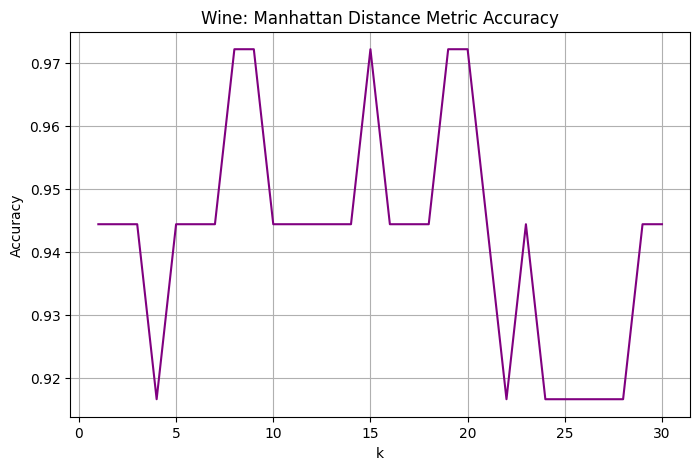

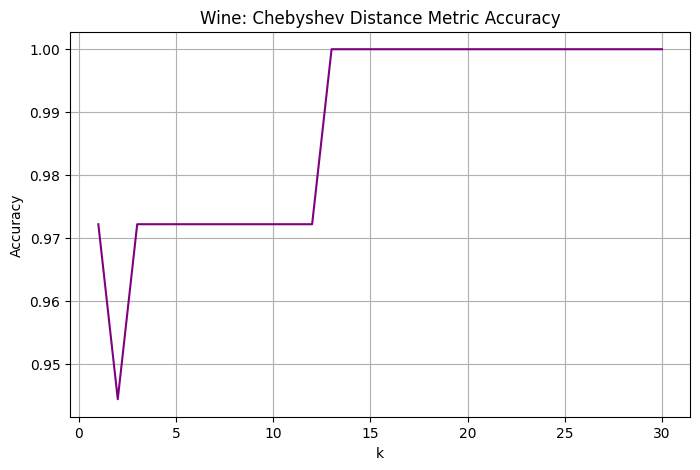

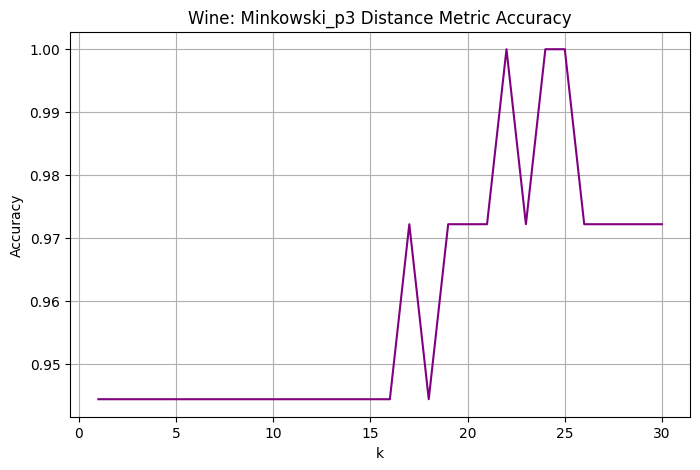

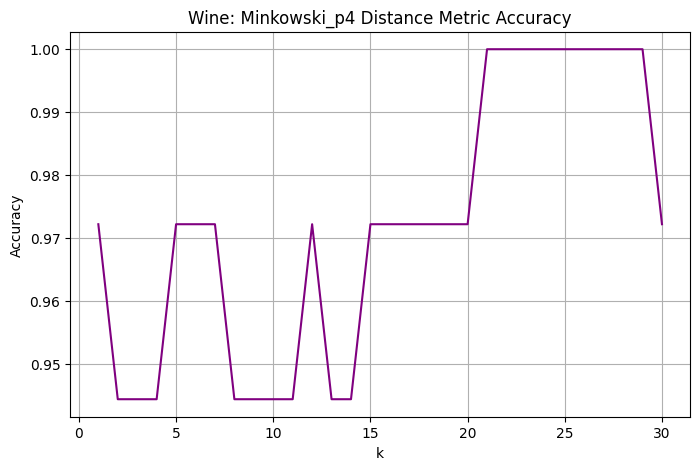

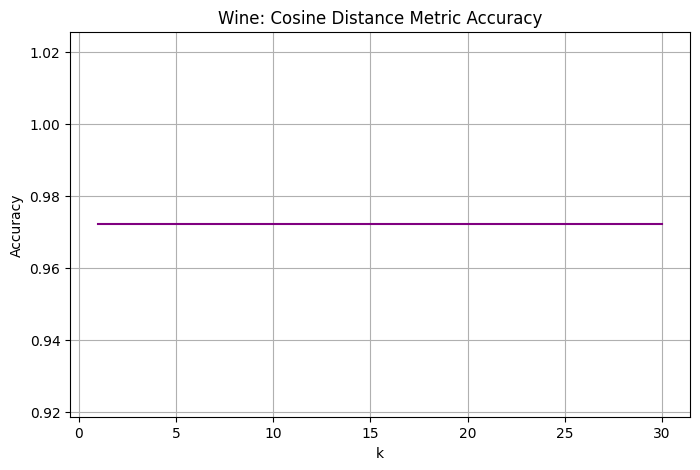

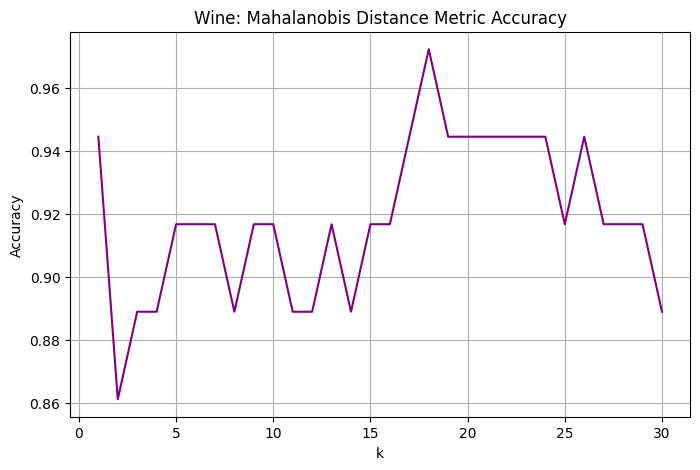

In [10]:
for name, acc in results.items():
    plt.figure(figsize=(8,5))
    plt.plot(k_values, acc, color= 'purple')
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title(f"Wine: {name.capitalize()} Distance Metric Accuracy")
    plt.grid(True)
    plt.savefig(f"../Results/Wine_Results/Plots/Accuracy_Curves/wine_{name}_curve.png", dpi=300, bbox_inches='tight')
    plt.show()

Cross Validation With Pipeline

In [11]:
def make_pipeline(metric, p=None, V=None):
    if metric == 'minkowski':
        return Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(metric='minkowski', p=p))
        ])
    elif metric == 'mahalanobis':
        return Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(metric='mahalanobis', metric_params={'VI': VI}))
        ])
    else:
        return Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(metric=metric))
        ])

cv_results = {}
for name, metric in distance_metrics_full.items():
    cv_scores_list = []
    for k in k_values:
        if isinstance(metric, dict) and name.startswith('minkowski'):
            pipe = make_pipeline('minkowski', p=metric['p'])
        elif name == 'mahalanobis':
            pipe = make_pipeline('mahalanobis', V=cov)
        else:
            pipe = make_pipeline(metric)

        pipe.named_steps['knn'].n_neighbors = k
        scores = cross_val_score(pipe, X, y, cv=5)
        cv_scores_list.append(np.mean(scores))
    cv_results[name] = cv_scores_list

Individual Cross Validation Plots

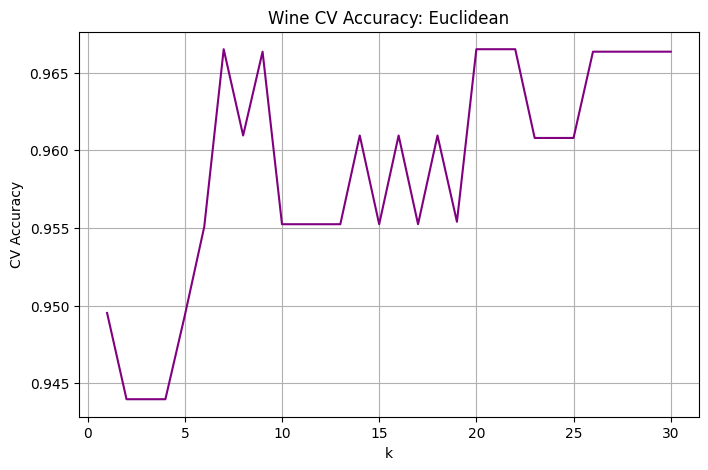

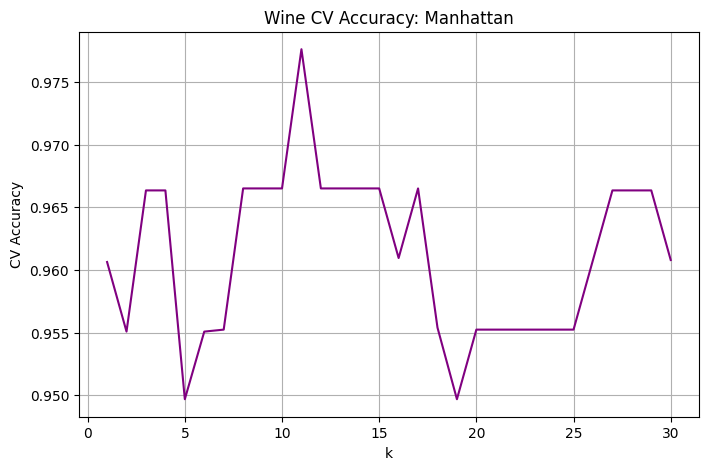

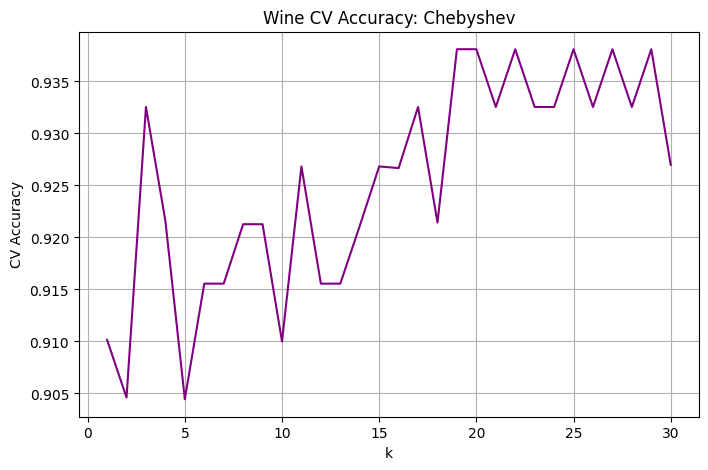

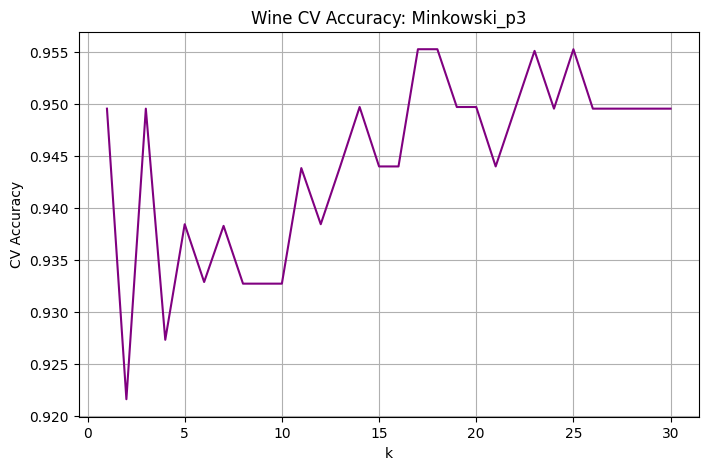

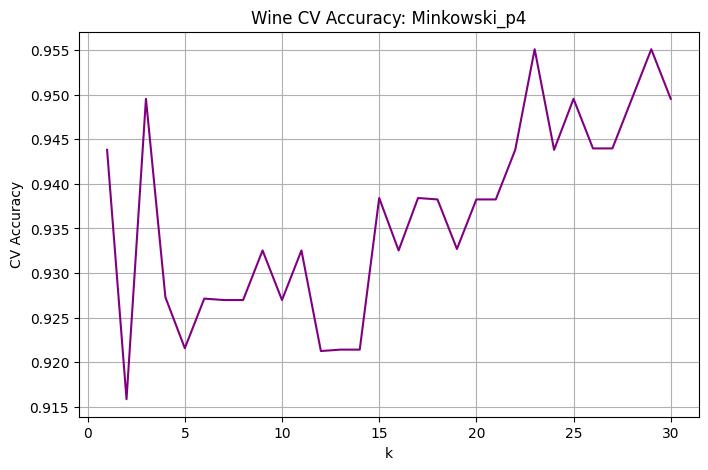

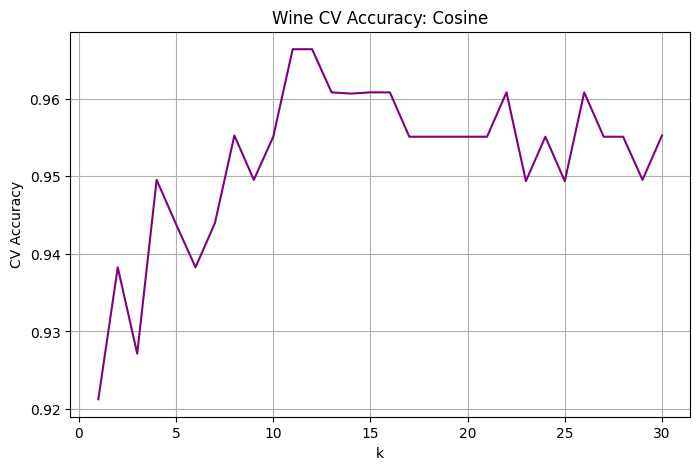

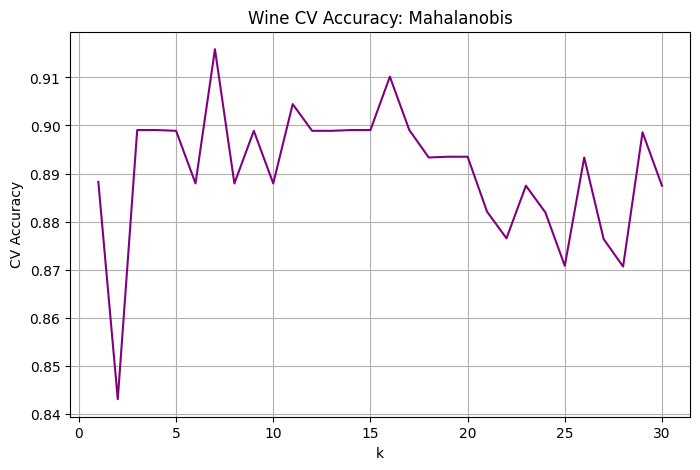

In [12]:
for name, scores in cv_results.items():
    plt.figure(figsize=(8,5))
    plt.plot(k_values, scores, color='purple')
    plt.xlabel("k")
    plt.ylabel("CV Accuracy")
    plt.title(f"Wine CV Accuracy: {name.capitalize()}")
    plt.grid(True)
    plt.savefig(f"../Results/Wine_Results/Plots/Cross_Validation_Plots/wine_cv_{name}.png", dpi=300, bbox_inches='tight')
    plt.show()

Confusion Matrices (CV-Selected k, Initial Test Split)

In [13]:
conf_mats = {}
for name, acc_list in results.items():
    best_k = np.argmax(acc_list) + 1
    metric = distance_metrics_full[name]

    if isinstance(metric, dict) and name.startswith('minkowski'):
        knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric['metric'], p=metric['p'])
    elif name == 'mahalanobis':
        knn = KNeighborsClassifier(n_neighbors=best_k, metric='mahalanobis', metric_params={'VI': VI})
    else:
        knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric)

    knn.fit(X_train_std, y_train)
    preds = knn.predict(X_test_std)
    cm = confusion_matrix(y_test, preds)
    conf_mats[name] = cm

Individual Plots of Confusion Matrices (CV-Selected k, Initial Test Split)

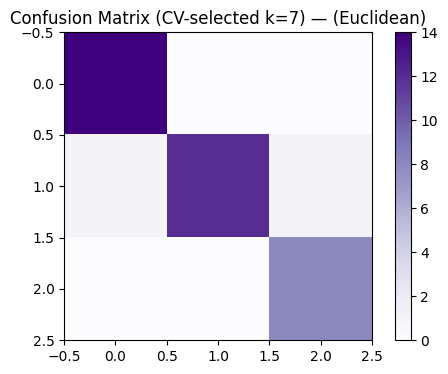

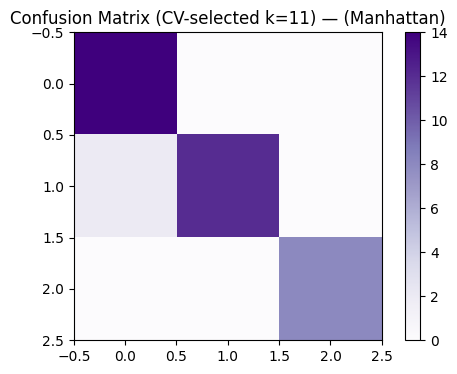

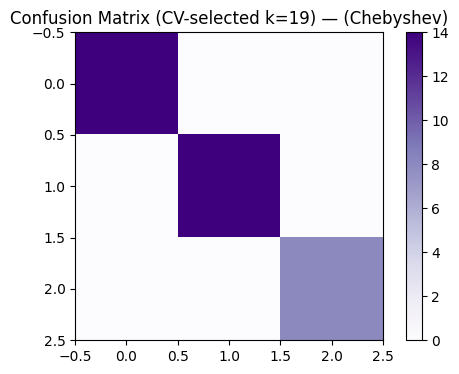

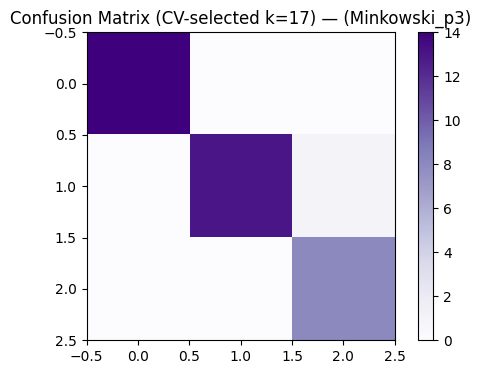

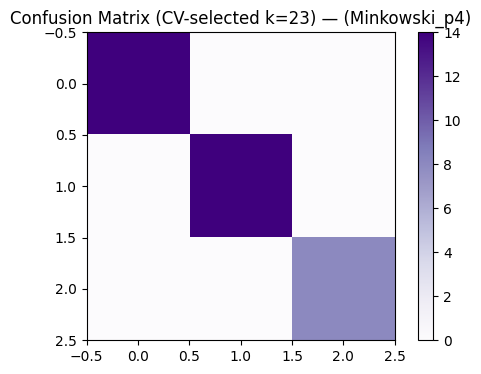

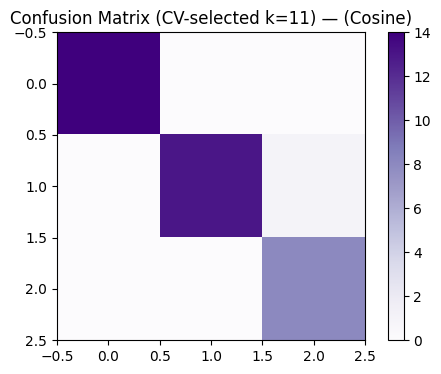

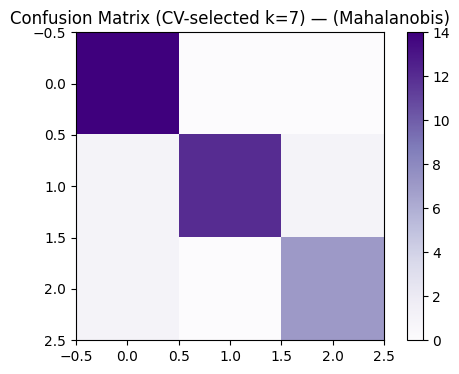

In [14]:
best_k_cv = {name: np.argmax(scores) + 1 for name, scores in cv_results.items()}
conf_mats = {}
for name, k_sel in best_k_cv.items():
    metric = distance_metrics_full[name]
    if isinstance(metric, dict) and name.startswith('minkowski'):
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric=metric['metric'], p=metric['p'])
    elif name == 'mahalanobis':
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric='mahalanobis', metric_params={'VI': VI})
    else:
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric=metric)
    knn.fit(X_train_std, y_train)
    preds = knn.predict(X_test_std)
    cm = confusion_matrix(y_test, preds)
    conf_mats[name] = cm
    plt.figure(figsize=(6,4))
    plt.imshow(cm, cmap='Purples')
    plt.title(f"Confusion Matrix (CV-selected k={k_sel}) — ({name.capitalize()})")
    plt.colorbar()
    plt.savefig(f"../Results/Wine_Results/Plots/Confusion_Matrices/wine_confusion_{name}.png", dpi=300, bbox_inches='tight')
    plt.show()

Classification Report For Each Distant Metrics (CV-Selected k, Initial Test Split)

In [15]:
for name, k_sel in best_k_cv.items():
    metric = distance_metrics_full[name]
    if isinstance(metric, dict) and name.startswith('minkowski'):
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric=metric['metric'], p=metric['p'])
    elif name == 'mahalanobis':
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric='mahalanobis', metric_params={'VI': VI})
    else:
        knn = KNeighborsClassifier(n_neighbors=k_sel, metric=metric)
    knn.fit(X_train_std, y_train)
    preds = knn.predict(X_test_std)
    report = classification_report(y_test, preds, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(f'../Results/Wine_Results/Classification_Reports/{name}_classification_report.csv')
    print(f"Classification Report for {name} (k={k_sel}):")
    display(df)


Classification Report for euclidean (k=7):


,precision,recall,f1-score,support
0,0.933333,1.000000,0.965517,14.000000
1,1.000000,0.857143,0.923077,14.000000
2,0.888889,1.000000,0.941176,8.000000
accuracy,0.944444,0.944444,0.944444,0.944444
macro avg,0.940741,0.952381,0.943257,36.000000
weighted avg,0.949383,0.944444,0.943604,36.000000


Classification Report for manhattan (k=11):


,precision,recall,f1-score,support
0,0.875000,1.000000,0.933333,14.000000
1,1.000000,0.857143,0.923077,14.000000
2,1.000000,1.000000,1.000000,8.000000
accuracy,0.944444,0.944444,0.944444,0.944444
macro avg,0.958333,0.952381,0.952137,36.000000
weighted avg,0.951389,0.944444,0.944160,36.000000


Classification Report for chebyshev (k=19):


,precision,recall,f1-score,support
0,1.0,1.0,1.0,14.0
1,1.0,1.0,1.0,14.0
2,1.0,1.0,1.0,8.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,36.0
weighted avg,1.0,1.0,1.0,36.0


Classification Report for minkowski_p3 (k=17):


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,14.000000
1,1.000000,0.928571,0.962963,14.000000
2,0.888889,1.000000,0.941176,8.000000
accuracy,0.972222,0.972222,0.972222,0.972222
macro avg,0.962963,0.976190,0.968046,36.000000
weighted avg,0.975309,0.972222,0.972525,36.000000


Classification Report for minkowski_p4 (k=23):


,precision,recall,f1-score,support
0,1.0,1.0,1.0,14.0
1,1.0,1.0,1.0,14.0
2,1.0,1.0,1.0,8.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,36.0
weighted avg,1.0,1.0,1.0,36.0


Classification Report for cosine (k=11):


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,14.000000
1,1.000000,0.928571,0.962963,14.000000
2,0.888889,1.000000,0.941176,8.000000
accuracy,0.972222,0.972222,0.972222,0.972222
macro avg,0.962963,0.976190,0.968046,36.000000
weighted avg,0.975309,0.972222,0.972525,36.000000


Classification Report for mahalanobis (k=7):


,precision,recall,f1-score,support
0,0.875000,1.000000,0.933333,14.000000
1,1.000000,0.857143,0.923077,14.000000
2,0.875000,0.875000,0.875000,8.000000
accuracy,0.916667,0.916667,0.916667,0.916667
macro avg,0.916667,0.910714,0.910470,36.000000
weighted avg,0.923611,0.916667,0.916382,36.000000


Results Summary

In [16]:
best_acc_cv = {name: np.max(scores) for name, scores in cv_results.items()}
best_k = best_k_cv
summary_df = pd.DataFrame({'Best CV Accuracy': best_acc_cv, 'Best k (CV)': best_k})
display(summary_df)
summary_df.to_csv('../Results/Wine_Results/Wine_Summary.csv')

,Best CV Accuracy,Best k (CV)
euclidean,0.966508,7
manhattan,0.977619,11
chebyshev,0.938095,19
minkowski_p3,0.955238,17
minkowski_p4,0.955079,23
cosine,0.966349,11
mahalanobis,0.915873,7
